# Context Analysis with the INDRA Database

The combination of large-scale assembly in the INDRA Database and contextual annotations from MEDLINE enables the exploration of the effect of context on the function of proteins and processes. In this case study, we explore the differential functionality of the tumor necrosis factor (TNF; [hgnc:11892](https://bioregistry.io/hgnc:11892)) to upregulate or downregulate various processes depending on the biological context (e.g., disease).

From https://en.wikipedia.org/wiki/Tumor_necrosis_factor:

> As an adipokine, TNF promotes insulin resistance, and is associated with obesity-induced type 2 diabetes.[7] As a cytokine, TNF is used by the immune system for cell signaling. If macrophages (certain white blood cells) detect an infection, they release TNF to alert other immune system cells as part of an inflammatory response.[7]
>
> TNF signaling occurs through two receptors: TNFR1 and TNFR2.[8][9] TNFR1 is constituitively expressed on most cell types, whereas TNFR2 is restricted primarily to endothelial, epithelial, and subsets of immune cells.[8][9] TNFR1 signaling tends to be pro-inflammatory and apoptotic, whereas TNFR2 signaling is anti-inflammatory and promotes cell proliferation.[8][9] Suppression of TNFR1 signaling has been important for treatment of autoimmune disease,[10] whereas TNFR2 signaling promotes wound healing.[9] 

Ideas:

1. Compare correspondence between results on apoptotic process ([go:0006915](https://bioregistry.io/go:0006915) and cell proliferation ([go:0008283](https://bioregistry.io/go:0008283))
2. Look at TNFR1 (hgnc:11916) and TNFR2 (hgnc:11917). Should easily be able to recover the following biases:    
   - activation of TNFR1 to apoptosis
   - inhibition of TNFR1 to autoimmune disease
   - activation ot TNFR2 to cell proliferation

In [1]:
import datetime
from functools import lru_cache
from textwrap import dedent

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pystow
import seaborn as sns
import numpy as np
from indra.assemblers.english import EnglishAssembler
from indra.literature import pubmed_client
from indra.preassembler import Preassembler
from indra.sources import SOURCE_INFO
from indra.tools.assemble_corpus import run_preassembly
from IPython.display import Markdown, display
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tabulate import tabulate
from tqdm.auto import tqdm
from indra.statements import stmt_from_json, Evidence
from indra.belief import BeliefScorer, SimpleScorer
from collections import Counter, defaultdict
from statsmodels.stats.multitest import multipletests

import json
from indra_cogex.analyses.context_specificity_analysis import df_binomtest, get_norm_counts_df, get_raw_counts_df
from indra_cogex.client import Neo4jClient, get_node_counter, get_stmts_for_stmt_hashes
from indra_cogex.info import env
from indra.databases.mesh_client import is_disease
from scipy.stats import binomtest, linregress

set_matplotlib_formats("svg")

In [2]:
env()

Key,Value
OS,posix
Platform,Darwin
Release,22.1.0
Time,Mon Feb 6 15:45:57 2023
Python,3.11.0
INDRA Version,1.22.0
INDRA Git Hash,e58abad59052cafb99d8fe2ea53a9e1780fade46
INDRA CoGEx Version,1.0.0
INDRA CoGEx Git Hash,69e937366c8342b2102ac55af2c804ed111ef65f
INDRA CoGEx Branch,indra-db-summary


In [3]:
client = Neo4jClient()

INFO: [2023-02-06 15:45:58] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-02-06 15:45:58] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


# Summarize TNF Statements

First, we query the INDRA Database for all statements where tumor necrosis factor (TNF; [hgnc:11892](https://bioregistry.io/hgnc:11892)) appears as the subject and a Gene Ontology (GO) term appears as the object. We group together statements of variying type and specificity, then count the number of associated evidence for each GO term. Due to the implicit bias of the databases and readers that feed into the INDRA database, GO terms with higher number of evidences typically correspond to more *canonical* biology.

In [4]:
%%time
targets_df = pd.DataFrame(
    client.query_tx(
        """\
        MATCH p=(:BioEntity {id: "hgnc:11892"})-[r:indra_rel]->(t:BioEntity)
        WHERE NOT t.id STARTS WITH "uniprot:" 
        RETURN t.id, t.name, sum(r.evidence_count) as count
        ORDER BY count DESC
        """
    ),
    columns=["curie", "name", "evidences"]
)
go_targets_df = targets_df[targets_df.curie.str.startswith("go:")]
go_targets_df.head(15)

CPU times: user 196 ms, sys: 22.2 ms, total: 218 ms
Wall time: 3.64 s


,curie,name,evidences
0,go:0006915,apoptotic process,15266
2,go:0006954,inflammatory response,4851
3,go:0008219,cell death,4704
5,go:0008283,cell population proliferation,2795
10,go:0030154,cell differentiation,1948
11,go:0007155,cell adhesion,1874
14,go:0070266,necroptotic process,1640
26,go:0070265,necrotic cell death,1003
27,go:0006351,"transcription, DNA-templated",983
39,go:0001525,angiogenesis,594


A log-log scaled histogram shows that the evidence counts for each object of statements where TNF is the subject vary across several orders of magnitude. Further, they follow a power-law distribution where most objects have a small number of evidences. This pattern is true both for all possible objects (left) and when objects are filtered to be only GO terms (right).

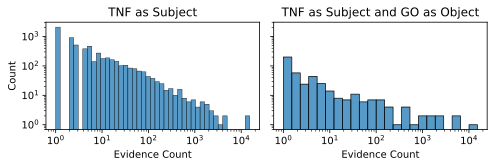

In [5]:
fix, (lax, rax) = plt.subplots(1, 2, figsize=(7, 2.5), sharey=True)

sns.histplot(targets_df["evidences"], log_scale=True, ax=lax)
lax.set_yscale("log")
lax.set_xlabel("Evidence Count")
lax.set_title("TNF as Subject")

sns.histplot(go_targets_df["evidences"], log_scale=True, ax=rax)
rax.set_yscale("log")
rax.set_xlabel("Evidence Count")
rax.set_title("TNF as Subject and GO as Object")

plt.tight_layout()
plt.show()

# Polarity of TNF to Apopotosis

In our first case study, we look at the polarity (i.e., activation or inhibition) of relationships between TNF and apopotosis ([go:0006915](https://bioregistry.io/go:0006915)), a form of programmed cell death.

The cypher query below does the following:

1. (Line 1) Find all statements between TNF and Apoptosis
2. (Line 2) Find all evidences attached to statements from line 1
3. (Line 2) Find all publications attached to those evidences
4. (Line 2) Find all MeSH annotations attached to those publications
5. (Line 3) Group by statement/evidence pairs, keyed by INDRA statement hash
6. (Line 3) Collect a list of PubMed/MeSH identifier pairs for each statement/evidence pair

In [6]:
%%time
res = client.query_tx(
    """\
    MATCH (:BioEntity {id: "hgnc:11892"})-[r:indra_rel]->(:BioEntity {id: 'go:0006915'})
    MATCH (e:Evidence {stmt_hash: r.stmt_hash})-[:has_citation]->(p:Publication)-[:annotated_with]->(a:BioEntity)
    RETURN r.stmt_hash, r.stmt_type, e, collect({pubmed: p.id, mesh: a.id, name: a.name})
    """
)
res = [
    (stmt_hash, stmt_type, Evidence._from_json(evidence), annotations)
    for stmt_hash, stmt_type, evidence, annotations in res
]

print(f"There are {len(res):,} evidences between TNF and Apoptosis")

There are 13,485 evidences between TNF and Apoptosis
CPU times: user 3.97 s, sys: 192 ms, total: 4.16 s
Wall time: 33.3 s


Next, we'll apply some post-processing that is more convenient from Python instead of in Cypher. First, this code removes all MeSH annotations that do not fall in the "disease" tree. Second, it creates a multi-level index of evidences based on the following:

1. Statement type (e.g., activation, inhibition)
2. MeSH annotation (i.e., which disease)
3. Publication

This index is useful for generating a comparsion for each MeSH annotation (which, after filtering, correspond exclusively to diseases) of whether there is a bias towards TNF's activation or inhibition of apoptosis.

In [7]:
# collect dictionary of stmt -> mesh ID -> pubmed -> evidence
dd = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for stmt_hash, stmt_type, evidence, annotations in res:
    for annotation in annotations:
        mesh_id = annotation["mesh"].removeprefix("mesh:")
        if not is_disease(mesh_id):
            continue
        name = annotation["name"]
        pubmed = annotation["pubmed"].removeprefix("pubmed:")
        dd[stmt_type][mesh_id, name][pubmed].append(evidence)

In the next code block, we generate that comparsing by doing the following:

1. Aggregate evidences in each publication by total count
2. Aggregate publications in each MeSH annotation by sum of total counts
3. Apply a cutoff for minimum number of annotations
4. Estimate an empirical expected activation/inhibition ratio `p` (note that this will be greater than 1.0, since activation is more commonly found/written about/extracted by readers)
5. Apply a binomial test for each MeSH annotation
6. Address multiple hypothesis testing by calculating family-wise false discovery rate (FDR)

Note: the implementation is rather long and complicated, so it lives `indra_cogex` package and is simply imported in this Jupyter notebook.

In [20]:
raw_count_df = get_raw_counts_df(dd, "Activation", "Inhibition", minimum=15)
raw_count_df.to_csv("tnf_apoptosis_raw.tsv", sep='\t')
raw_count_df

INFO: [2023-02-06 15:49:35] indra_cogex.analyses.context_specificity_analysis - using calculated ratio of 0.91


,,Activation,Inhibition,p,q,mlq,sign
D001249,Asthma,19,23,2.286189e-14,3.955107e-12,11.40,-1.0
D015464,"Leukemia, Myelogenous, Chronic, BCR-ABL Positive",11,10,2.969595e-06,2.568699e-04,3.59,-1.0
D001172,"Arthritis, Rheumatoid",153,33,5.728287e-05,3.303312e-03,2.48,-1.0
D016766,Feline Infectious Peritonitis,11,8,8.940383e-05,3.866715e-03,2.41,-1.0
D064726,Triple Negative Breast Neoplasms,26,9,2.169148e-03,7.505250e-02,1.12,-1.0
...,...,...,...,...,...,...,...
D015470,"Leukemia, Myeloid, Acute",74,6,1.000000e+00,1.000000e+00,-0.00,1.0
D013964,Thyroid Neoplasms,33,3,1.000000e+00,1.000000e+00,-0.00,1.0
D056486,Chemical and Drug Induced Liver Injury,128,11,1.000000e+00,1.000000e+00,-0.00,1.0
D004938,Esophageal Neoplasms,26,2,1.000000e+00,1.000000e+00,-0.00,1.0


Given that the previous block does not account for systematic nor random errors associated with the statements used to link statement polarities (i.e., activation or inhibition) to MeSH annotations, the following cell uses an alternatve implementation that aggregates evidences together using a simple "belief" scorer that accounts for these errors based on empirical estimates. We provide a more detailed description of how belief scoring works in [Bachman *et al.*, (2022)](https://doi.org/10.1101/2022.08.30.505688).

Here, we slightly modify steps 1 and 2 from before generate the comparison by doing the following:

1. Aggregate evidences in each publication with a simple belief scorer
2. Aggregate publications in each mesh annotation by sum of belief scores
3. Apply a cutoff for minimum number of annotations
4. Estimate an empirical expected activation/inhibition ratio `p` (note that this will be greater than 1.0, since activation is more commonly found/written about/extracted by readers)
5. Apply a binomial test for each MeSH annotation
6. Address multiple hypothesis testing by calculating family-wise false discovery rate (FDR)

In [9]:
belief_df = get_norm_counts_df(dd, "Activation", "Inhibition", minimum=15)
belief_df.to_csv("tnf_apoptosis_norm.tsv", sep='\t')
belief_df

INFO: [2023-02-06 15:46:36] indra_cogex.analyses.context_specificity_analysis - using calculated ratio of 0.90


,,Activation,Inhibition,p,q,mlq,sign
D001172,"Arthritis, Rheumatoid",66,19,0.001160,0.107875,0.97,-1.0
D000860,Hypoxia,13,5,0.033410,1.000000,-0.00,-1.0
D064726,Triple Negative Breast Neoplasms,13,5,0.033410,1.000000,-0.00,-1.0
D003424,Crohn Disease,17,5,0.072545,1.000000,-0.00,-1.0
D009361,Neoplasm Invasiveness,41,8,0.164823,1.000000,-0.00,-1.0
...,...,...,...,...,...,...,...
D000230,Adenocarcinoma,49,5,1.000000,1.000000,-0.00,1.0
D058186,Acute Kidney Injury,21,2,1.000000,1.000000,-0.00,1.0
D001327,Autoimmune Diseases,39,4,1.000000,1.000000,-0.00,1.0
D000086382,COVID-19,22,2,1.000000,1.000000,-0.00,1.0


We perform a sanity check that the normalization procedure doesn't make severe changes. In the first row, we show on the left a scatter plot of the direct (i.e., unnormalized) counts of publications containing evidences for activation (x-axis) vs. inhibition (y-axis) where each dot represents a MeSH term.

On the right, the normalization appears to remove outliers from the relatively linear relationship. As the goal of this analysis was to identify meaningful outliers (i.e., contexts in which there is a skew towards one polarity of the TNF-Apoptosis relationship), we investigate the meaning of this further in the next cells.

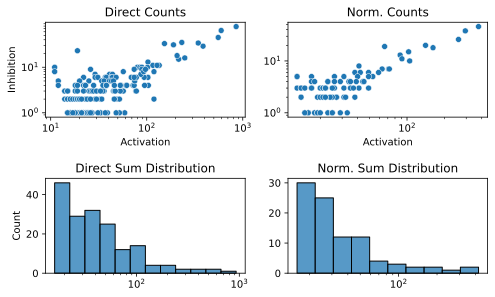

In [10]:
fig, ((lax, rax), (lax0, rax0)) = plt.subplots(2, 2, figsize=(7, 4.3))

sns.histplot(x=raw_count_df["Activation"] + raw_count_df["Inhibition"], log_scale=True, ax=lax0)
lax0.set_title("Direct Sum Distribution")

sns.histplot(x=belief_df["Activation"] + belief_df["Inhibition"], log_scale=True, ax=rax0)
rax0.set_title("Norm. Sum Distribution")
rax0.set_ylabel("")

sns.scatterplot(data=raw_count_df, x="Activation", y="Inhibition", ax=lax)
lax.set_title("Direct Counts")
lax.set_yscale("log")
lax.set_xscale("log")

sns.scatterplot(data=belief_df, x="Activation", y="Inhibition", ax=rax)
rax.set_title("Norm. Counts")
rax.set_ylabel("")
rax.set_yscale("log")
rax.set_xscale("log")

plt.tight_layout()
plt.show()

The following scatter plot investigates the effect of normalization on which MeSH annoations (i.e., diseases) had a significant deviation from the expected ratio of activation to inhibition statements. Here's how to interpret this plot:

- Dots in the bottom-left quadrant were neither significant before nor after normalization (this is the most populated box)
- Dots in the bottom-right quadrant were significant before normalization, but not after
- Dots in the top-right quadrant were significant both before and after normalization
- Dots in the top-left quadrant were not significant before normalization, but were after (we did not observe this happening for a relatively lenient *p*-value cutoff of $p<0.05$)

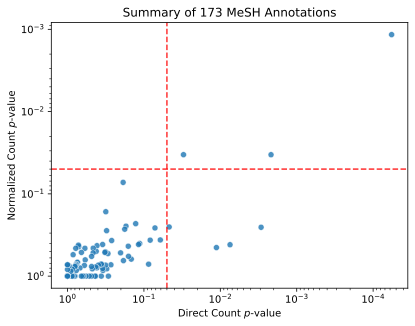

In [11]:
columns = ["p", "mlq", "sign"]
p_cutoff = 0.05
join_df = raw_count_df[columns].join(belief_df[columns], rsuffix="_norm", lsuffix="_direct")
ax = sns.scatterplot(data=join_df, x="p_direct", y="p_norm", alpha=0.8)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Direct Count $p$-value")
ax.set_ylabel("Normalized Count $p$-value")
ax.invert_yaxis()
ax.invert_xaxis()
ax.axvline(p_cutoff, linestyle='--', color='red', alpha=0.8)
ax.axhline(p_cutoff, linestyle='--', color='red', alpha=0.8)
ax.set_title(f'Summary of {len(join_df.index)} MeSH Annotations')
plt.show()

The following lists the MeSH annotations that showed a significant deviation from the expected activation/inhibition ratio. Notably, this includes asthma, whose connections to TNF remains an area of active research. Even further, the application of multiple hypothesis test correction seems to result in no significant MeSH annotations.
This may suggest that absolute *p*-values are less valuable than a rank-based approach. 

References:

- TNF-alpha in asthma ([pubmed:17475560](https://pubmed.ncbi.nlm.nih.gov/17475560/))
- Targeting TNF-α: A novel therapeutic approach for asthma ([pubmed:18036647](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3992375))

In [12]:
idx = (join_df["p_direct"] < p_cutoff) & (join_df["p_norm"] > p_cutoff) 
join_df[idx].sort_values("p_direct", ascending=True)

,,p_direct,mlq_direct,sign_direct,p_norm,mlq_norm,sign_norm
D005909,Glioblastoma,0.002926,1.07,1.0,0.254871,-0.0,1.0
D006528,"Carcinoma, Hepatocellular",0.007463,0.73,-1.0,0.414890,-0.0,-1.0
D008113,Liver Neoplasms,0.011247,0.65,-1.0,0.449693,-0.0,-1.0
D009374,"Neoplasms, Experimental",0.046734,0.21,1.0,0.252619,-0.0,1.0


The following are significantly different between activation/inhibition even after applying normalization, representing the highest confident differential conditions.

In [13]:
idx = (join_df["p_direct"] < p_cutoff) & (join_df["p_norm"] < p_cutoff)
join_df[idx].sort_values("p_direct", ascending=True)

,,p_direct,mlq_direct,sign_direct,p_norm,mlq_norm,sign_norm
D001172,"Arthritis, Rheumatoid",0.000057,2.48,-1.0,0.00116,0.97,-1.0
D064726,Triple Negative Breast Neoplasms,0.002169,1.12,-1.0,0.03341,-0.00,-1.0
D000860,Hypoxia,0.030328,0.32,-1.0,0.03341,-0.00,-1.0


Overall, we see two major themes emerging from the significantly regulated:

1. Inflammatory disease like arthritis, Crohn's disease, and asthma
2. Cancer

However, there isn't a correspondence of the sign of disregulation to these types, suggesting that either 1) one or more the aggregation, ratio estimation, or statistical aren't chosen appropriately or 2) there is no signal here.

# Process vs. Process

In a second case study, we investigate how TNF differentially activates different processes depending on the context. Given the high-level knowledge that TNF differentially activates apoptotis and inflammatory response depending on the diease context, we investigate if this relationship can be recapitulated in a semi-automated way from the INDRA Database.

In [14]:
@lru_cache
def _get_res(target_curie):
    return [
        (stmt_hash, Evidence._from_json(evidence), annotations)
        for stmt_hash, evidence, annotations in client.query_tx(
            """\
            MATCH (:BioEntity {id: "hgnc:11892"})-[r:indra_rel {stmt_type: 'Activation'}]->(:BioEntity {id: '%s'})
            MATCH (e:Evidence {stmt_hash: r.stmt_hash})-[:has_citation]->(p:Publication)-[:annotated_with]->(a:BioEntity)
            RETURN r.stmt_hash, e, collect({pubmed: p.id, mesh: a.id, name: a.name})
            """ % target_curie
        )
    ]

In [15]:
# collect dictionary of target -> mesh ID -> pubmed -> evidence
cross_dd = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
c1, c2 = 'apoptotic process', 'inflammatory response'
for target_curie, target_name in [
    ('go:0006915', 'apoptotic process'),
    ('go:0006954', 'inflammatory response'),
    # ('go:0008219', 'cell death'),
    # ('go:0008283', 'cell population proliferation'),
]:    
    for stmt_hash, evidence, annotations in _get_res(target_curie):
        for annotation in annotations:
            mesh_id = annotation["mesh"].removeprefix("mesh:")
            if not is_disease(mesh_id):
                continue
            if mesh_id in {
                "D007249",  # inflammation, skip since redundant
            }:
                continue
            name = annotation["name"]
            pubmed = annotation["pubmed"].removeprefix("pubmed:")
            cross_dd[target_name][mesh_id, name][pubmed].append(evidence)

In [16]:
cross_raw_counts_df = get_raw_counts_df(cross_dd, c1, c2, minimum=10)
cross_raw_counts_df

INFO: [2023-02-06 15:46:56] indra_cogex.analyses.context_specificity_analysis - using calculated ratio of 0.71


,,apoptotic process,inflammatory response,p,q,mlq,sign
D001943,Breast Neoplasms,344,14,3.642940e-35,1.067381e-32,31.97,1.0
D011471,Prostatic Neoplasms,249,6,1.045509e-29,1.531671e-27,26.81,1.0
D009765,Obesity,38,108,1.111561e-28,1.085624e-26,25.96,-1.0
D004195,"Disease Models, Animal",596,481,2.560159e-26,1.875317e-24,23.73,-1.0
D009369,Neoplasms,555,84,4.966041e-22,2.910100e-20,19.54,1.0
...,...,...,...,...,...,...,...
D001927,Brain Diseases,11,4,1.000000e+00,1.000000e+00,-0.00,1.0
D011183,Postoperative Complications,8,3,1.000000e+00,1.000000e+00,-0.00,1.0
D001424,Bacterial Infections,23,9,1.000000e+00,1.000000e+00,-0.00,1.0
D007035,Hypothermia,16,6,1.000000e+00,1.000000e+00,-0.00,1.0


In [17]:
cross_norm_counts_df = get_norm_counts_df(cross_dd, c1, c2, minimum=10)
cross_norm_counts_df.head(25)

INFO: [2023-02-06 15:46:56] indra_cogex.analyses.context_specificity_analysis - using calculated ratio of 0.67


,,apoptotic process,inflammatory response,p,q,mlq,sign
D001943,Breast Neoplasms,141,9,1.830616e-15,3.350027e-13,12.47,1.0
D009765,Obesity,22,63,1.505496e-14,1.377529e-12,11.86,-1.0
D011471,Prostatic Neoplasms,105,4,6.262001e-14,3.819821e-12,11.42,1.0
D009369,Neoplasms,260,48,4.099500e-12,1.875521e-10,9.73,1.0
D011014,Pneumonia,7,33,1.885504e-10,6.900945e-09,8.16,-1.0
D009336,Necrosis,162,25,7.437312e-10,2.254167e-08,7.65,1.0
D007333,Insulin Resistance,23,50,8.622495e-10,2.254167e-08,7.65,-1.0
D004195,"Disease Models, Animal",295,249,1.130660e-09,2.586385e-08,7.59,-1.0
D008175,Lung Neoplasms,91,8,5.525882e-09,1.123596e-07,6.95,1.0
D010051,Ovarian Neoplasms,49,1,6.851309e-08,1.253790e-06,5.90,1.0


themes:
- cancers (e.g., breast, prostate, lung, ovarian, liver) show bias towards apoptotic process
- inflammatory disease (arthritis)
- diseases associated with inflammation (athersclerosis, insulin resistance)
    
    
Asthma - TNF directly implicated in disease ()

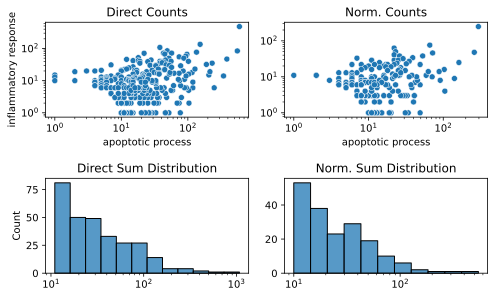

In [18]:
fig, ((lax, rax), (lax0, rax0)) = plt.subplots(2, 2, figsize=(7, 4.3))

sns.histplot(x=cross_raw_counts_df[c1] + cross_raw_counts_df[c2], log_scale=True, ax=lax0)
lax0.set_title("Direct Sum Distribution")

sns.histplot(x=cross_norm_counts_df[c1] + cross_norm_counts_df[c2], log_scale=True, ax=rax0)
rax0.set_title("Norm. Sum Distribution")
rax0.set_ylabel("")

sns.scatterplot(data=cross_raw_counts_df, x=c1, y=c2, ax=lax)
lax.set_title("Direct Counts")
lax.set_yscale("log")
lax.set_xscale("log")

sns.scatterplot(data=cross_norm_counts_df, x=c1, y=c2, ax=rax)
rax.set_title("Norm. Counts")
rax.set_ylabel("")
rax.set_yscale("log")
rax.set_xscale("log")

plt.tight_layout()
plt.show()

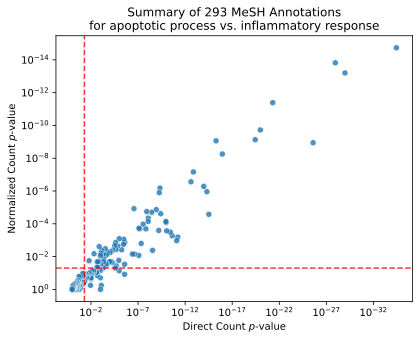

In [19]:
columns = ["p", "mlq", "sign"]
p_cutoff = 0.05
cross_join_df = cross_raw_counts_df[columns].join(
    cross_norm_counts_df[columns], rsuffix="_norm", lsuffix="_direct"
)
ax = sns.scatterplot(
    data=cross_join_df, 
    x="p_direct", y="p_norm", 
    alpha=0.8,
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Direct Count $p$-value")
ax.set_ylabel("Normalized Count $p$-value")
ax.invert_yaxis()
ax.invert_xaxis()
ax.axvline(p_cutoff, linestyle='--', color='red', alpha=0.8)
ax.axhline(p_cutoff, linestyle='--', color='red', alpha=0.8)
ax.set_title(f'Summary of {len(cross_join_df.index)} MeSH Annotations\nfor {c1} vs. {c2}')
plt.show()